In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

In [166]:
df = pd.read_excel('./dataset/bulanan-ekspor-impor.xlsx', parse_dates=[0], index_col=0)
df = df.dropna()
df = df.loc[:,['Nilai-Ekspor']]

In [103]:
df.head()

,Nilai-Ekspor
Bulan-Tahun,
2019-01-01,1.402809e+10
2019-02-01,1.278856e+10
2019-03-01,1.444779e+10
2019-04-01,1.306807e+10
2019-05-01,1.475189e+10


In [104]:
df.tail()

,Nilai-Ekspor
Bulan-Tahun,
2022-11-01,2.409404e+10
2022-12-01,2.382786e+10
2023-01-01,2.232384e+10
2023-02-01,2.132128e+10
2023-03-01,2.341599e+10


(array([7.50e+09, 1.00e+10, 1.25e+10, 1.50e+10, 1.75e+10, 2.00e+10,
        2.25e+10, 2.50e+10, 2.75e+10, 3.00e+10]),
 [Text(0, 7500000000.0, '0.75'),
  Text(0, 10000000000.0, '1.00'),
  Text(0, 12500000000.0, '1.25'),
  Text(0, 15000000000.0, '1.50'),
  Text(0, 17500000000.0, '1.75'),
  Text(0, 20000000000.0, '2.00'),
  Text(0, 22500000000.0, '2.25'),
  Text(0, 25000000000.0, '2.50'),
  Text(0, 27500000000.0, '2.75'),
  Text(0, 30000000000.0, '3.00')])

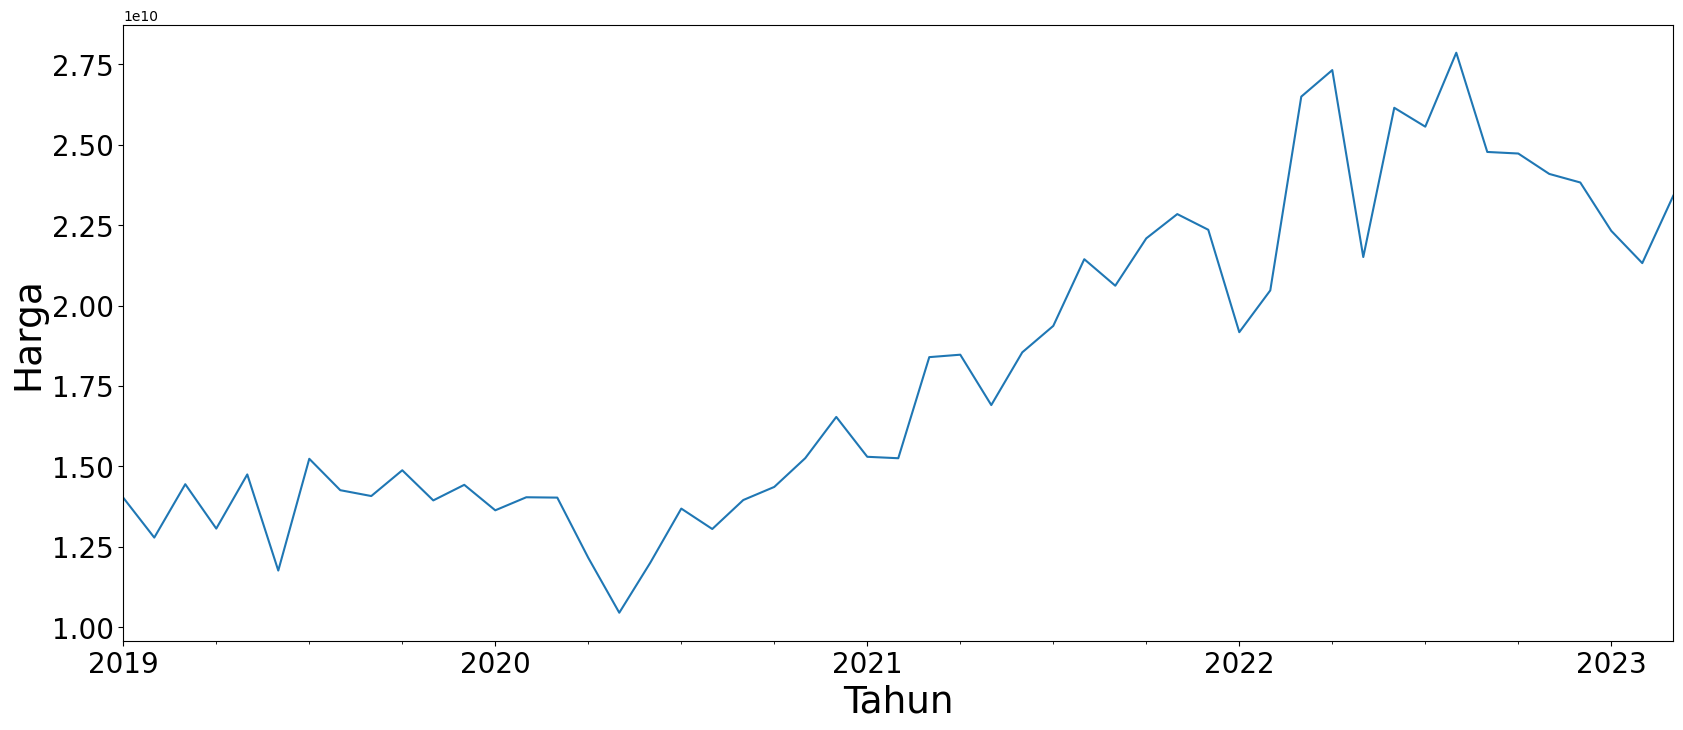

In [125]:
df['Nilai-Ekspor'].plot(figsize=(20,8))
plt.xlabel('Tahun',fontsize=27)
plt.ylabel('Harga', fontsize=27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [167]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
         
adf_test(df['Nilai-Ekspor'])

1. ADF :  -0.6535766202831429
2. P-Value :  0.8584107050420464
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression: 46
5. Critical Values :
	 1% :  -3.5812576580093696
	 5% :  -2.9267849124681518
	 10% :  -2.6015409829867675


In [168]:
# Membuat objek Series dari deret waktu
series = pd.Series(df["Nilai-Ekspor"])

# Melakukan diferensiasi pertama
differenced = series.diff().dropna()

In [169]:
adf_test(differenced)

1. ADF :  -6.673604412693112
2. P-Value :  4.522946952470663e-09
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 47
5. Critical Values :
	 1% :  -3.5778480370438146
	 5% :  -2.925338105429433
	 10% :  -2.6007735310095064


In [170]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(differenced, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2285.945, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2283.303, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2280.060, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2281.966, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2281.920, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2283.822, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2281.576, Time=0.14 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.968 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1138.030
Date:                Thu, 08 Jun 2023   AIC                           2280.060
Time:                        22:44:58   BIC                           2283.884
Sample:                

In [171]:
# Memisahkan data train dan test
train = differenced.loc['2019-02-01':'2021-12-01']
test = df.loc['2022-01-01':'2023-03-01']

train.shape, test.shape


((35,), (15, 1))

In [172]:
model=ARIMA(train,order=(0,0,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Nilai-Ekspor   No. Observations:                   35
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -784.304
Date:                Thu, 08 Jun 2023   AIC                           1574.608
Time:                        22:45:04   BIC                           1579.274
Sample:                    02-01-2019   HQIC                          1576.219
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.38e+08   4.69e-11   5.08e+18      0.000    2.38e+08    2.38e+08
ma.L1         -0.4082      0.153     -2.672      0.008      -0.708      -0.109
sigma2      1.723e+18   9.18e-21   1.88e+38      0.000    1.72e+18    1.72e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.71   Prob(JB):                         0.79
Heteroskedasticity (H):               0.98   Skew:                            -0.27
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [173]:
# Melakukan prediksi
pred_diff = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# Inversi differencing
pred = pd.Series(differenced.iloc[-len(test)-1] + pred_diff.cumsum(), index=test.index)

In [119]:
# start=len(train)
# end=len(train)+len(test)-1
# pred=model.predict(start=start,end=end,type='levels')

# pred.index=df.index[start:end+1]
# print(pred)

In [178]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Menerapkan Simple Exponential Smoothing
fit = SimpleExpSmoothing(train).fit(smoothing_level=0.2, optimized=False)

# Melakukan prediksi untuk periode April 2023 hingga Desember 2023
index_future_dates = pd.date_range(start='2023-04-01', end='2023-12-01', freq='MS')  # Mengatur frekuensi menjadi bulanan
fcast = fit.forecast(len(index_future_dates)).rename('Seasonal Exponential Smoothing')
fcast.index = index_future_dates

# Menampilkan hasil prediksi
print(fcast)

2023-04-01    4.730473e+08
2023-05-01    4.730473e+08
2023-06-01    4.730473e+08
2023-07-01    4.730473e+08
2023-08-01    4.730473e+08
2023-09-01    4.730473e+08
2023-10-01    4.730473e+08
2023-11-01    4.730473e+08
2023-12-01    4.730473e+08
Freq: MS, Name: Seasonal Exponential Smoothing, dtype: float64


In [175]:
index_future_dates = pd.date_range(start='2023-04-01', end='2023-12-01', freq='M')
pred = model.predict(start=len(df), end=len(df)+7, typ='levels').rename('ARIMA Predictions')
pred.index = index_future_dates
print(pred)


2023-04-30    2.379896e+08
2023-05-31    2.379896e+08
2023-06-30    2.379896e+08
2023-07-31    2.379896e+08
2023-08-31    2.379896e+08
2023-09-30    2.379896e+08
2023-10-31    2.379896e+08
2023-11-30    2.379896e+08
Freq: M, Name: ARIMA Predictions, dtype: float64


<Axes: xlabel='Bulan-Tahun'>

<Figure size 1000x600 with 0 Axes>

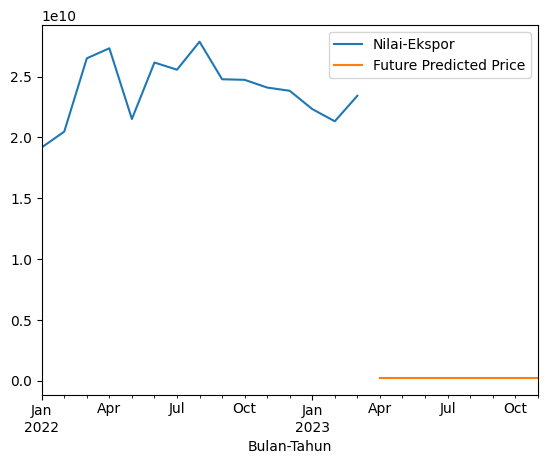

In [180]:
plt.figure(figsize=(10,6), dpi=100)
test.plot(label='Actual Price of Nilai-Ekspor',legend=True)
pred.plot(label='Future Predicted Price', legend=True)